In [2]:
# newton-raphson method

def nrbase(f, x0, delta):
    dfdx = (f(x0+delta)-f(x0-delta))/delta/2
    x1 = x0 - f(x0)/dfdx
    return x1

In [3]:
def g(x):
    return x**2 - 1

In [4]:
import numpy as np

In [5]:
x0 = -10
delta = 0.1
x1 = nrbase(g,x0,delta)

In [6]:
while abs(x1-x0) > 1e-5:
    x0 = x1
    x1 = nrbase(g,x0,delta)
x1

-1.0000000000139897

In [7]:
def nrmethod(f,x0,delta,eps):
    dfdx = (f(x0+delta)-f(x0-delta))/delta/2
    x1 = x0 - f(x0)/dfdx
    while abs(x1-x0) > eps:
        x0 = x1
        dfdx = (f(x0+delta)-f(x0-delta))/delta/2
        x1 = x0 - f(x0)/dfdx
    return x1

In [8]:
def h(x):
    return 2*x**3 -5* x**2 + 3*x + 5

In [9]:
nrmethod(h,10,1e-3,1e-5)

-0.6815201528763917

In [10]:
def rkheun(f,y1,ini,fin,h):
    interval=np.linspace(ini,fin,int(1/h))
    for i in range(len(interval)):
        k1=f(interval[i],y1)
        k2=f(interval[i]+h,y1+h*k1)
        y1=y1+(k1+k2)*h/2
    return y1

In [11]:
def oderhs(x,y):
    return y

In [12]:
rkheun(oderhs,1,0,1,1e-5)

2.718254645731375

In [13]:
from scipy.integrate import solve_ivp
sol = solve_ivp(oderhs,[0,1],[1],'RK45')
sol.y[0][-1] - rkheun(oderhs,1,0,1,1e-5)

np.float64(7.235377031467038e-05)

In [76]:
from scipy.differentiate import jacobian

def nrmethod2D(f,x0,eps):
    jac = jacobian(f,x0).df
    x1 = x0 - np.linalg.inv(jac)@f(x0)
    while True:
        x0 = x1
        jac = jacobian(f,x0).df
        x1 = x0 - np.linalg.inv(jac)@f(x0)
        if (abs(x1-x0) < eps).all():
            break
    return x1

In [77]:
def func(x):
    x1, x2 = x
    return [x1**2-x2,x1-x2**2]

In [78]:
nrmethod2D(func,[0.3,1.2],1e-4)

array([1., 1.])

In [80]:
from scipy.optimize import fsolve
fsolve(func,[0.3,1.2])-nrmethod2D(func,[0.3,1.2],1e-4)

array([-2.96511704e-11, -2.70858891e-11])

In [ ]:
def rkheun2D(f,y1,y2,ini,fin,point):
    interval=np.linspace(ini,fin,point)
    h = interval[1]-interval[0]

    fval=np.empty(0)
    fdotval=np.empty(0)
    for i in range(len(interval)):

        k1g=(f(interval[i]+h,y2+h)-f(interval[i]-h,y2+h))/h/2
        k2g=(f(interval[i]+2.*h,y2+h*k1g)-f(interval[i],y2+h*k1g))/h/2
        y2=y2+(k1g+k2g)*h/2
        fdotval=np.append(fdotval,y1)

        k1f=f(interval[i],y1)
        k2f=f(interval[i]+h,y1+h*k1f)
        y1=y1+(k1f+k2f)*h/2
        fval=np.append(fval,y1)
    return fval, fdotval

In [104]:
def func(t,y):
    return - y**2

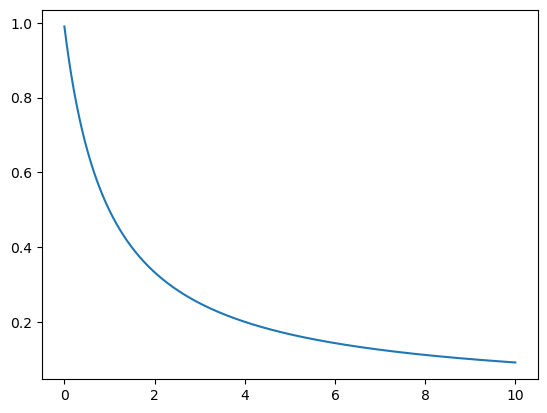

In [107]:
y, ydot = rkheun2D(func,1.,0.,0.,10.,1000)
import matplotlib.pyplot as plt
plt.plot(np.linspace(0.,10.,1000),y)

In [81]:
rhatlist=np.linspace(0,1,1000)

In [84]:
def pres(rho, K, n):
    return K*rho**(1+1/n)
def enthalpy(rho, K, n):
    return 1. + K*(n+1)*rho**(1/n)

In [83]:
rhoc=1.28*10**(-3)

In [ ]:
def dhdrhat(dphidrhat):
    return - dphidrhat
def d2phidrhat2(rhat,phi,dphidrhar,Rs,rho,K,n):
    return -(2./rhat)*dphidrhat + 4.*np.pi* Rs**2 * (enthalpy(rho,K,n)/(K(n+1)))**n